<a href="https://colab.research.google.com/github/chiglo-k/HSE-Data-Engeneer/blob/main/hw_2_ai.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [26]:
from typing import Dict, List, Tuple, Optional, Any, Union
from pathlib import Path
from dataclasses import dataclass
from xml.etree import ElementTree as ET
import time
import glob
import shutil
import os

import albumentations as A
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
from albumentations.pytorch.transforms import ToTensorV2
from matplotlib.patches import Rectangle
from matplotlib.axes import Axes
from matplotlib.figure import Figure
from PIL import Image
from torch import nn, Tensor
from torch.utils.data import Dataset, DataLoader
from torchvision.models import ResNet50_Weights
from tqdm.notebook import tqdm

from dataclasses import dataclass
from typing import Dict, List
import time


# Типы для аннотаций
BBox = List[float]  # [xmin, ymin, xmax, ymax, class_id]
BBoxBatch = List[List[BBox]]
TransformOutput = Dict[str, Union[Tensor, List[BBox]]]

In [27]:
# Harry Potter:
!wget -q https://github.com/markblumenau/hw3_iad_dl/raw/main/harry/data.zip
!unzip -q data.zip

print(f"Files: {os.listdir('data/')}")

replace data/class_dict? [y]es, [n]o, [A]ll, [N]one, [r]ename: All
Files: ['class_dict', 'images', 'xmls']


In [28]:
"""
Задача 1: Dataset
"""

def get_xml_data(
    image_name: str,
    root: Path,
    class_dict: Dict[str, int],
    xml_prefix: str = "/xmls/"
) -> List[BBox]:
    """Парсит XML файл и возвращает список bbox"""
    filename: str = image_name.split("/")[-1].split(".")[0]
    tree: ET.ElementTree = ET.parse(str(root) + xml_prefix + filename + ".xml")
    treeroot: ET.Element = tree.getroot()

    bboxes: List[BBox] = []
    for member in treeroot.findall("object"):
        bndbox: ET.Element = member.find("bndbox")
        xmin: int = int(bndbox.find("xmin").text)
        ymin: int = int(bndbox.find("ymin").text)
        xmax: int = int(bndbox.find("xmax").text)
        ymax: int = int(bndbox.find("ymax").text)

        class_name: str = member.find("name").text
        class_id: int = class_dict[class_name]

        res: BBox = [xmin, ymin, xmax, ymax, class_id]
        bboxes.append(res)

    return bboxes


class PascalDataset(Dataset):
    """Dataset для PascalVOC формата"""

    def __init__(
        self,
        *,
        transform: A.Compose,
        root: str = "dataset",
        train: bool = True,
        seed: int = 42
    ) -> None:
        self.root: Path = Path(root)
        self.transform: A.Compose = transform

        assert self.root.is_dir(), f"No data at `{root}`"

        self.filenames: np.ndarray = np.array(glob.glob(root + "/images/*"))
        with open(str(self.root) + "/class_dict", "r") as f:
            self.class_dict: Dict[str, int] = eval(f.readline())

        self.class_dict_inv: Dict[int, str] = {v: k for k, v in self.class_dict.items()}

        np.random.seed(seed)
        permutation: np.ndarray = np.random.permutation(len(self.filenames))

        if train:
            self.filenames = self.filenames[
                permutation[: int(len(self.filenames) * 0.9)]
            ].tolist()
        else:
            self.filenames = self.filenames[
                permutation[int(len(self.filenames) * 0.9) :]
            ].tolist()

    def __getitem__(self, idx: int) -> TransformOutput:
        fname: str = self.filenames[idx]
        image: np.ndarray = np.array(Image.open(fname))
        bboxes: List[BBox] = get_xml_data(fname, self.root, self.class_dict)

        return self.transform(image=image, bboxes=bboxes)

    def __get_raw_item__(self, idx: int) -> Tuple[str, List[BBox]]:
        fname: str = self.filenames[idx]
        return fname, get_xml_data(fname, self.root, self.class_dict)

    def __len__(self) -> int:
        return len(self.filenames)


#датасеты
mean: Tuple[float, float, float] = (0.485, 0.456, 0.406)
std: Tuple[float, float, float] = (0.229, 0.224, 0.225)

train_transform: A.Compose = A.Compose(
    [
        A.Resize(512, 512),
        A.Normalize(mean=mean, std=std),
        ToTensorV2(),
    ],
    bbox_params=dict(format="pascal_voc", min_visibility=0.3),
)

test_transform: A.Compose = A.Compose(
    [
        A.Resize(512, 512),
        A.Normalize(mean=mean, std=std),
        ToTensorV2(),
    ],
    bbox_params=dict(format="pascal_voc", min_visibility=0.5),
)

train_ds: PascalDataset = PascalDataset(
    root="./data/", transform=train_transform, train=True
)
test_ds: PascalDataset = PascalDataset(
    root="./data/", transform=test_transform, train=False
)

print(f"Train size: {len(train_ds)}")
print(f"Test size: {len(test_ds)}")
print(f"Classes: {train_ds.class_dict}")
print(f"Number of classes: {len(train_ds.class_dict)}")

Train size: 254
Test size: 29
Classes: {'snitch': 0, 'quaffle': 1, 'bludger': 2}
Number of classes: 3


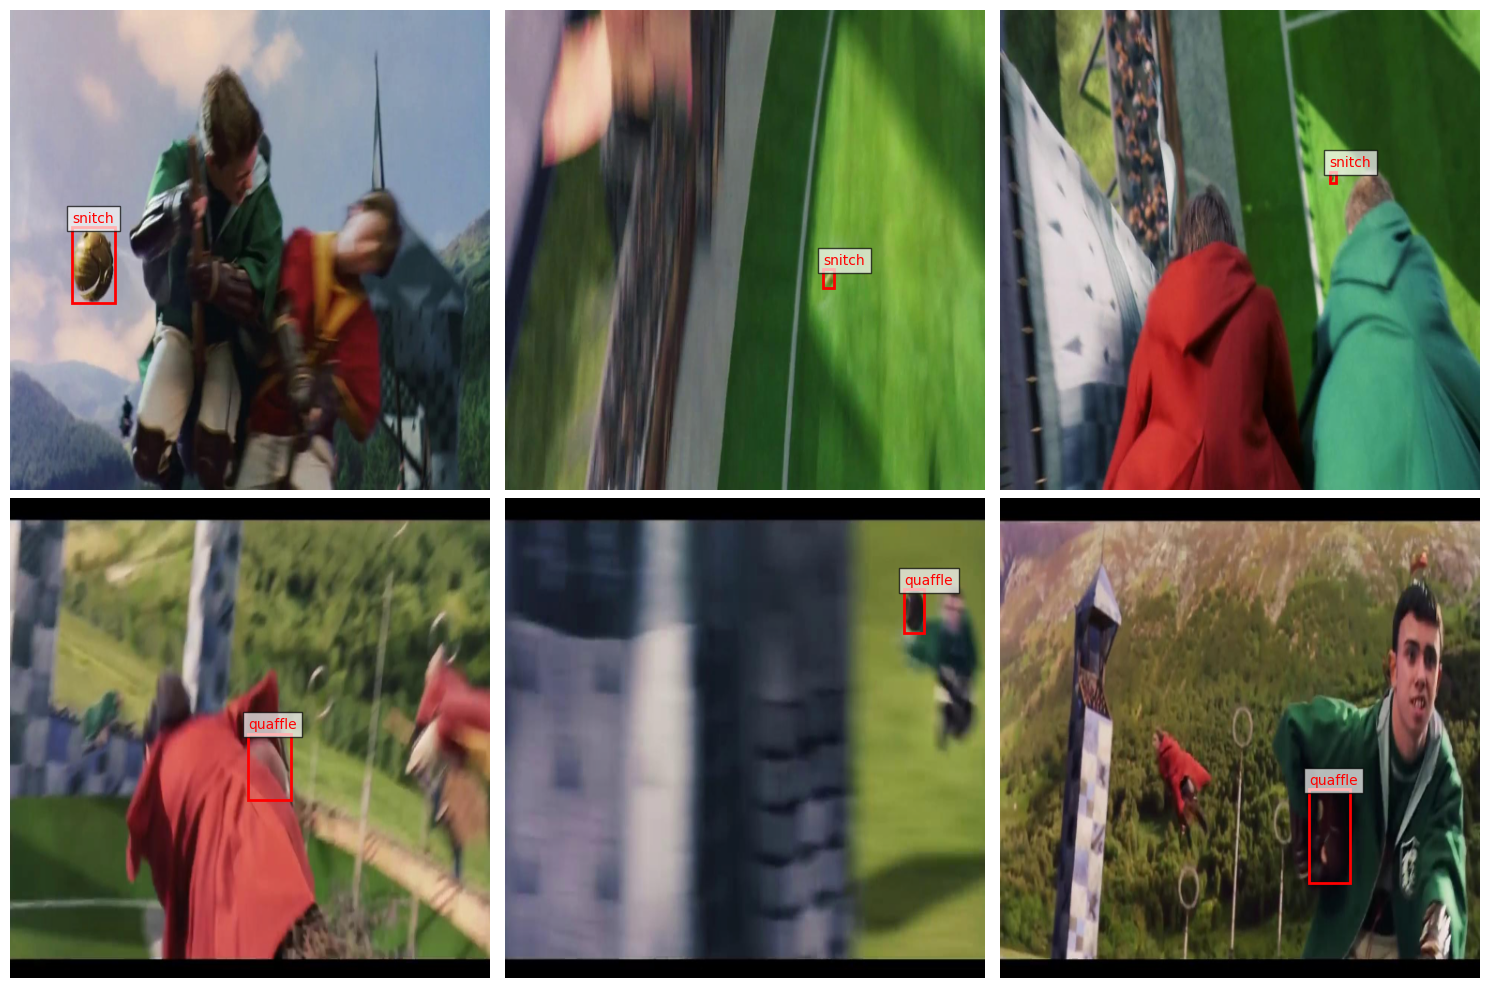

In [30]:
"""
Задача 2: Визуализация
"""

def visualize(images: List[Tensor], bboxes: BBoxBatch) -> None:
    """Визуализирует изображения с bbox"""
    mean: np.ndarray = np.array([0.485, 0.456, 0.406])
    std: np.ndarray = np.array([0.229, 0.224, 0.225])

    fig, axes = plt.subplots(
        2, len(images) // 2 + len(images) % 2, figsize=(15, 10), dpi=100
    )

    for i, ax in enumerate(axes.reshape(-1)):
        ax.axis(False)

        if i >= len(images):
            break

        # Денормализация
        img: np.ndarray = images[i].permute(1, 2, 0).cpu().numpy()
        img = img * std + mean
        img = np.clip(img, 0, 1)

        ax.imshow(img)

        for bbox in bboxes[i]:
            xmin, ymin, xmax, ymax, class_id = bbox
            w: float = xmax - xmin
            h: float = ymax - ymin

            rect: Rectangle = Rectangle(
                (xmin, ymin), w, h, fill=False, color='red', linewidth=2
            )
            ax.add_patch(rect)

            class_name: str = train_ds.class_dict_inv[int(class_id)]
            ax.text(
                xmin, ymin - 5, class_name, color='red', fontsize=10,
                bbox=dict(facecolor='white', alpha=0.7)
            )

    fig.tight_layout()
    plt.show()


# Тест
out: List[TransformOutput] = [train_ds[i] for i in range(6)]
visualize([o["image"] for o in out], [o["bboxes"] for o in out])

In [31]:
"""
Задача 3.1: collate_fn
"""

def collate_fn(batch: List[TransformOutput], downsample: int = 32) -> Dict[str, Tensor]:
    """Создает grid таргеты для обучения"""
    imgs: List[Tensor]
    batch_boxes: List[List[BBox]]
    imgs, batch_boxes = map(list, (zip(*[(b["image"], b["bboxes"]) for b in batch])))

    imgs_tensor: Tensor = torch.stack(imgs)
    b, _, h, w = imgs_tensor.shape

    target: Tensor = imgs_tensor.new_zeros(b, 6, h // downsample, w // downsample)

    for i, boxes in enumerate(batch_boxes):
        if len(boxes) == 0:
            continue

        xmin, ymin, xmax, ymax, classes = map(
            torch.squeeze,
            torch.split(imgs_tensor.new_tensor(boxes), 1, dim=-1)
        )

        # Размеры клетки
        x_cell: float = w / (w // downsample)
        y_cell: float = h / (h // downsample)

        # Ширина и высота бокса нормированные
        w_box: Tensor = (xmax - xmin) / w
        h_box: Tensor = (ymax - ymin) / h

        # Координаты центра
        cx: Tensor = (xmin + xmax) / 2
        cy: Tensor = (ymin + ymax) / 2

        # Индексы на grid 16x16
        cx_idx: Tensor = (cx / x_cell).long().clamp(0, w // downsample - 1)
        cy_idx: Tensor = (cy / y_cell).long().clamp(0, h // downsample - 1)

        # Сдвиги относительно начала клетки
        cx_box: Tensor = (cx - cx_idx * x_cell) / x_cell
        cy_box: Tensor = (cy - cy_idx * y_cell) / y_cell

        # Записываем в target
        target[i, :, cy_idx, cx_idx] = torch.stack(
            [cx_box, cy_box, w_box, h_box, torch.ones_like(cx_box), classes]
        )

    return {"image": imgs_tensor, "target": target}


# Тест
def test_collate_fn() -> None:
    target1: BBox = [100, 200, 200, 300, 2]
    target2_1: BBox = [0, 250, 200, 300, 0]
    target2_2: BBox = [0, 100, 100, 300, 1]

    result: Dict[str, Tensor] = collate_fn([
        {"image": torch.rand((3, 512, 512)), "bboxes": [target1]},
        {"image": torch.rand((3, 512, 512)), "bboxes": [target2_1, target2_2]},
    ])

    assert result["image"].shape == (2, 3, 512, 512)
    assert result["target"].shape == (2, 6, 16, 16)
    assert np.allclose(
        result["target"][0, :, 7, 4],
        torch.tensor([22 / 32, 26 / 32, 100 / 512, 100 / 512, 1, 2]),
        atol=0.01
    )

    print("Test passed!")

test_collate_fn()

Test passed!


In [32]:
"""
Задача 3.2: decode_prediction
"""

def decode_prediction(pred: Tensor, upsample: int = 32, threshold: float = 0.7) -> BBoxBatch:
    """Декодирует предсказания из grid формата в bbox"""
    b, c, h, w = pred.shape
    img_w: int = w * upsample
    img_h: int = h * upsample
    result: BBoxBatch = []

    for batch_idx in range(b):
        bboxes_per_image: List[BBox] = []

        for y in range(h):
            for x in range(w):
                confidence: float = pred[batch_idx, 4, y, x].item()

                if confidence < threshold:
                    continue

                cx_box: float = pred[batch_idx, 0, y, x].item()
                cy_box: float = pred[batch_idx, 1, y, x].item()
                w_box: float = pred[batch_idx, 2, y, x].item()
                h_box: float = pred[batch_idx, 3, y, x].item()

                if c == 6:
                    class_id: float = pred[batch_idx, 5, y, x].item()
                else:
                    class_logits: Tensor = pred[batch_idx, 5:, y, x]
                    class_id: float = torch.argmax(class_logits).item()

                cx: float = (x + cx_box) * upsample
                cy: float = (y + cy_box) * upsample
                w_pix: float = w_box * img_w
                h_pix: float = h_box * img_h

                xmin: float = cx - w_pix / 2
                ymin: float = cy - h_pix / 2
                xmax: float = cx + w_pix / 2
                ymax: float = cy + h_pix / 2

                bboxes_per_image.append([xmin, ymin, xmax, ymax, class_id])

        result.append(bboxes_per_image)

    return result


# Тест
def test_decode_predictions() -> None:
    target1: List[BBox] = [[100, 200, 200, 300, 2]]
    target2: List[BBox] = [[0, 250, 200, 300, 0], [0, 100, 100, 300, 1]]
    result: Dict[str, Tensor] = collate_fn([
        {"image": torch.rand((3, 512, 512)), "bboxes": target1},
        {"image": torch.rand((3, 512, 512)), "bboxes": target2},
    ])

    target: Tensor = result["target"]
    target = torch.cat([target, torch.zeros(2, 2, 16, 16)], dim=1)

    target[0, 5:, 7, 4] = torch.tensor([0.5, 0.6, 0.9])
    target[1, 5:, 8, 3] = torch.tensor([0.9, 0.6, 0.5])
    target[1, 5:, 6, 1] = torch.tensor([0.6, 0.9, 0.5])

    actual: BBoxBatch = decode_prediction(target, threshold=0.7)
    expected: BBoxBatch = [target1, [target2[1], target2[0]]]

    assert actual == expected or actual == [target1, target2]
    print("Test passed!")

test_decode_predictions()

Test passed!


In [33]:
"""
Задача 3.3: Модель
"""

C: int = len(train_ds.class_dict)
print(f"Number of classes: {C}")


class Detector(nn.Module):
    """YOLO-like детектор на базе ResNet50"""

    def __init__(self, num_classes: int = C) -> None:
        super().__init__()
        self.num_classes: int = num_classes

        model: torchvision.models.ResNet = torchvision.models.resnet50(
            weights=ResNet50_Weights.DEFAULT
        )

        self.backbone: nn.Sequential = nn.Sequential(*list(model.children())[:-2])

        self.conv1: nn.Sequential = nn.Sequential(
            nn.Conv2d(2048, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )

        self.conv2: nn.Sequential = nn.Sequential(
            nn.Conv2d(512, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )

        self.conv3: nn.Sequential = nn.Sequential(
            nn.Conv2d(128, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU()
        )

        self.final: nn.Conv2d = nn.Conv2d(32, 5 + num_classes, kernel_size=3, padding=1)
        self.sigmoid: nn.Sigmoid = nn.Sigmoid()

    def forward(self, img: Tensor) -> Tensor:
        x: Tensor = self.backbone(img)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.final(x)
        x = self.sigmoid(x)
        return x


# Проверка
model_test: Detector = Detector()
test_input: Tensor = torch.rand(2, 3, 512, 512)
test_output: Tensor = model_test(test_input)
print(f"Input: {test_input.shape}")
print(f"Output: {test_output.shape}")
assert test_output.shape == (2, 5 + C, 16, 16)
print("Model test passed!")

total_params: int = sum(p.numel() for p in model_test.parameters())
print(f"Total parameters: {total_params:,}")

Number of classes: 3
Input: torch.Size([2, 3, 512, 512])
Output: torch.Size([2, 8, 16, 16])
Model test passed!
Total parameters: 33,576,232


In [34]:
"""
Задача 3.4: Loss Function
"""

def special_loss(pred: Tensor, target: Tensor, C: int = C) -> Tensor:
    """Loss function для YOLO-like детектора"""
    b, c, h, w = pred.shape

    # Flatten
    pred_flat: Tensor = pred.permute(0, 2, 3, 1).reshape(-1, c)
    target_flat: Tensor = target.permute(0, 2, 3, 1).reshape(-1, 6)

    # Маска объектов
    mask: Tensor = target_flat[:, 4] == 1

    if mask.sum() == 0:
        confidence_loss: Tensor = nn.BCELoss(reduction='sum')(
            pred_flat[:, 4], target_flat[:, 4]
        )
        return confidence_loss

    # Localization loss
    localization_loss: Tensor = nn.MSELoss(reduction='sum')(
        pred_flat[mask][:, :2], target_flat[mask][:, :2]
    )

    # Box loss
    pred_wh: Tensor = pred_flat[mask][:, 2:4].clamp(min=1e-6)
    target_wh: Tensor = target_flat[mask][:, 2:4].clamp(min=1e-6)
    box_loss: Tensor = nn.MSELoss(reduction='sum')(
        torch.sqrt(pred_wh), torch.sqrt(target_wh)
    )

    # Classification loss
    classification_loss: Tensor = nn.CrossEntropyLoss(reduction='sum')(
        pred_flat[mask][:, 5:], target_flat[mask][:, 5].long()
    )

    # Confidence loss
    confidence_loss_obj: Tensor = nn.BCELoss(reduction='sum')(
        pred_flat[mask][:, 4], target_flat[mask][:, 4]
    )

    confidence_loss_noobj: Tensor = 0.1 * nn.BCELoss(reduction='sum')(
        pred_flat[~mask][:, 4], target_flat[~mask][:, 4]
    )

    return (localization_loss + box_loss + classification_loss +
            confidence_loss_obj + confidence_loss_noobj)


# Тест
test_pred: Tensor = torch.rand(2, 5 + C, 16, 16)
test_target: Tensor = torch.zeros(2, 6, 16, 16)
test_target[0, :, 5, 5] = torch.tensor([0.5, 0.5, 0.3, 0.3, 1.0, 0])
loss: Tensor = special_loss(test_pred, test_target, C=C)
print(f"Test loss: {loss.item():.3f}")
print("Loss test passed!")

Test loss: 54.372
Loss test passed!


Device: cpu
Starting training for 20 epochs...


Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 0:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 0: Loss 92.405


Epoch 1:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 1: Loss 30.670


Epoch 2:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 2: Loss 20.104


Epoch 3:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 3: Loss 15.525


Epoch 4:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 4: Loss 12.411


Epoch 5:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 5: Loss 11.586


Epoch 6:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 6: Loss 10.506


Epoch 7:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 7: Loss 9.199


Epoch 8:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 8: Loss 9.155


Epoch 9:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 9: Loss 8.990


Epoch 10:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 10: Loss 8.498


Epoch 11:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 11: Loss 8.486


Epoch 12:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 12: Loss 8.453


Epoch 13:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 13: Loss 7.299


Epoch 14:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 14: Loss 7.524


Epoch 15:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 15: Loss 8.741


Epoch 16:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 16: Loss 10.868


Epoch 17:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 17: Loss 10.880


Epoch 18:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 18: Loss 10.397


Epoch 19:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 19: Loss 9.095
Training complete!


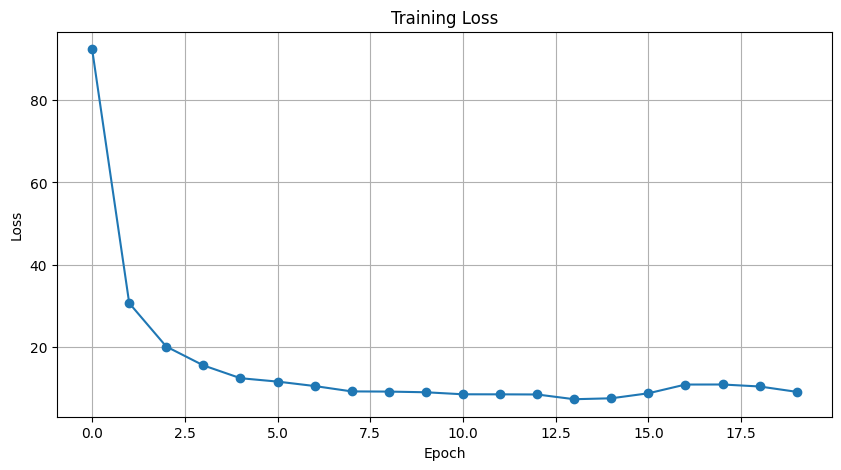

Model saved!


In [35]:
"""
Задача 4: Обучение
"""

loader: DataLoader = torch.utils.data.DataLoader(
    train_ds, batch_size=10, collate_fn=collate_fn, shuffle=True
)

device: torch.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

torch.manual_seed(21)
EPOCHS: int = 20
model: Detector = Detector().to(device)
opt: torch.optim.AdamW = torch.optim.AdamW(model.parameters(), lr=1e-3)

train_losses: List[float] = []

print(f"Starting training for {EPOCHS} epochs...")

for e in tqdm(range(EPOCHS), desc="Epochs"):
    pbar = tqdm(loader, leave=False, desc=f"Epoch {e}")
    epoch_losses: List[float] = []
    model.train()

    for batch in pbar:
        images: Tensor = batch["image"].to(device)
        targets: Tensor = batch["target"].to(device)

        predictions: Tensor = model(images)
        loss: Tensor = special_loss(predictions, targets, C=C)

        opt.zero_grad()
        loss.backward()
        opt.step()

        epoch_losses.append(loss.item())
        pbar.set_description(f"Epoch {e} | Loss: {loss.item():.3f}")

    avg_loss: float = np.mean(epoch_losses)
    train_losses.append(avg_loss)
    print(f"Epoch {e}: Loss {avg_loss:.3f}")

print("Training complete!")

# График
plt.figure(figsize=(10, 5))
plt.plot(train_losses, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.grid(True)
plt.show()

# Сохранение
torch.save(model.state_dict(), "detector_model.pth")
print("Model saved!")

Found 18 bboxes


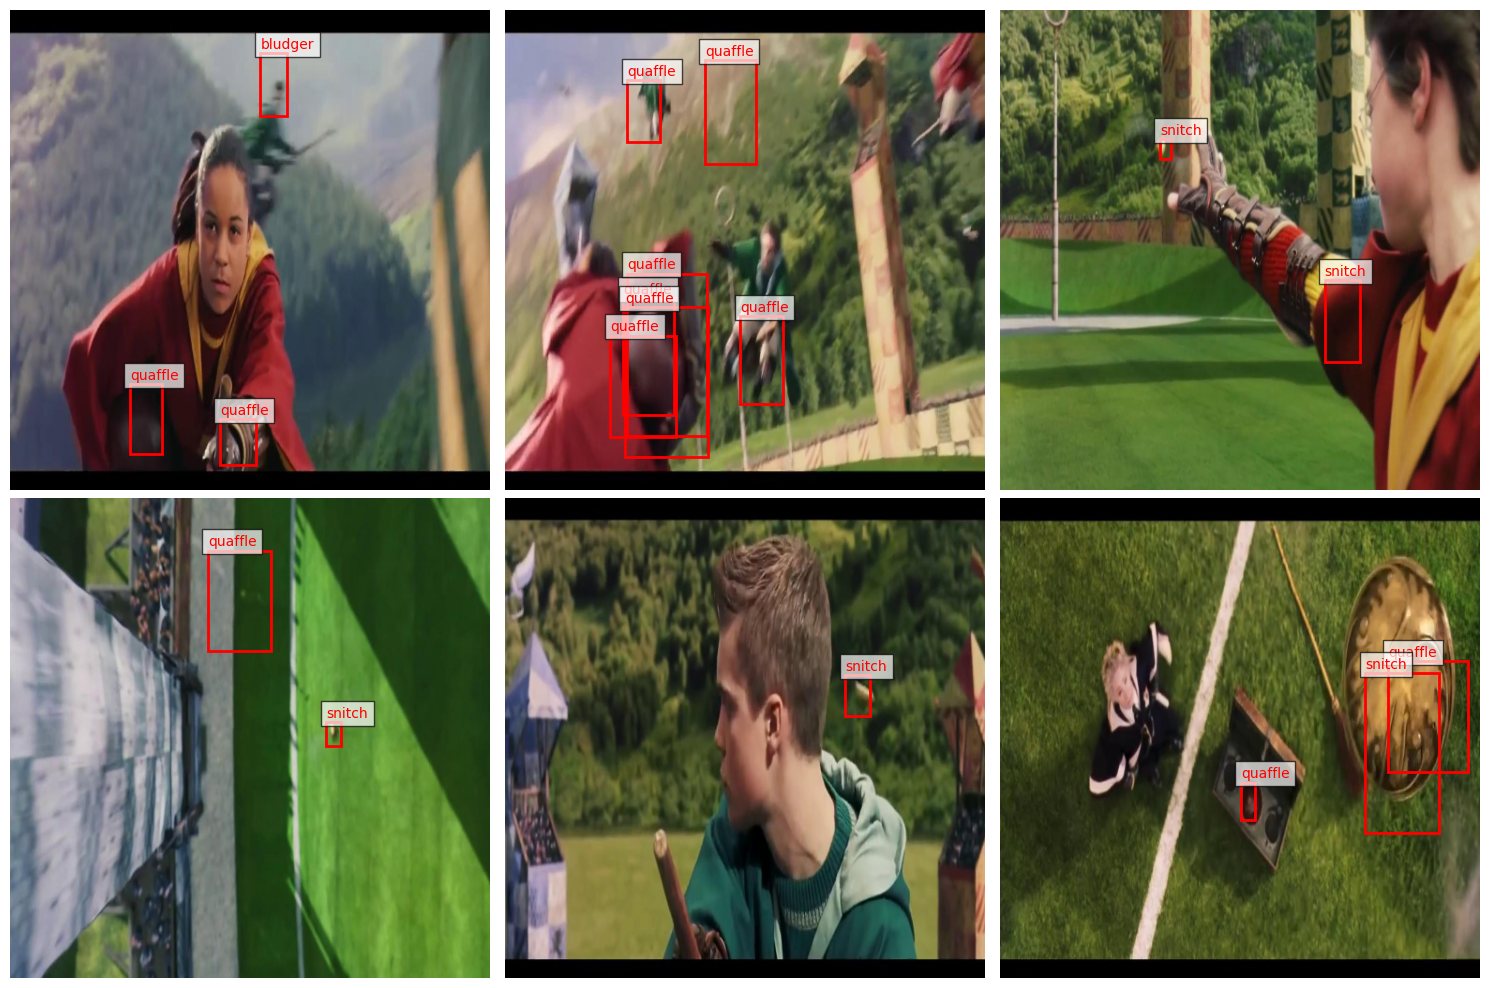

In [36]:
test_loader: DataLoader = torch.utils.data.DataLoader(
    test_ds, batch_size=6, collate_fn=collate_fn
)

batch: Dict[str, Tensor] = next(iter(test_loader))

model.eval()
with torch.no_grad():
    predictions: Tensor = model(batch["image"].to(device)).cpu()

decoded_preds: BBoxBatch = decode_prediction(predictions, threshold=0.1)

print(f"Found {sum(len(p) for p in decoded_preds)} bboxes")
visualize([batch["image"][i] for i in range(6)], decoded_preds)

In [37]:
"""
Задача 5.1: Подготовка данных для YOLO
"""

# Создаем папки
!rm -rf train valid
!mkdir -p train/images train/labels valid/images valid/labels

print("Folders created!")


def annotation2txt(bboxes: List[BBox], w_im: int, h_im: int) -> List[str]:
    """Конвертирует bbox в YOLO формат"""
    result: List[str] = []

    for bbox in bboxes:
        xmin, ymin, xmax, ymax, class_id = bbox

        x_center: float = (xmin + xmax) / 2 / w_im
        y_center: float = (ymin + ymax) / 2 / h_im
        width: float = (xmax - xmin) / w_im
        height: float = (ymax - ymin) / h_im

        line: str = f"{int(class_id)} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}"
        result.append(line)

    return result


# Копируем train
print("Processing train...")
for i in tqdm(range(len(train_ds))):
    fname: str
    bboxes: List[BBox]
    fname, bboxes = train_ds.__get_raw_item__(i)

    shutil.copyfile(fname, "./train/images/" + fname.split("/")[-1])

    img: np.ndarray = np.array(Image.open(fname))
    h_im, w_im = img.shape[:2]

    txt_path: str = "./train/labels/" + fname.split("/")[-1].split(".")[0] + ".txt"
    with open(txt_path, "w", encoding="utf8") as f:
        f.write("\n".join(annotation2txt(bboxes, w_im, h_im)))

# Копируем valid
print("Processing valid...")
for i in tqdm(range(len(test_ds))):
    fname: str
    bboxes: List[BBox]
    fname, bboxes = test_ds.__get_raw_item__(i)

    shutil.copyfile(fname, "./valid/images/" + fname.split("/")[-1])

    img: np.ndarray = np.array(Image.open(fname))
    h_im, w_im = img.shape[:2]

    txt_path: str = "./valid/labels/" + fname.split("/")[-1].split(".")[0] + ".txt"
    with open(txt_path, "w", encoding="utf8") as f:
        f.write("\n".join(annotation2txt(bboxes, w_im, h_im)))

print("Data prepared!")

# YAML
nc: int = len(train_ds.class_dict)
names: List[str] = list(train_ds.class_dict.keys())

with open("data.yaml", "w", encoding="utf-8") as f:
    f.write(f"""train: ../train/images
val: ../valid/images

nc: {nc}
names: {names}""")

print(f"YAML created! Classes: {nc}, Names: {names}")

Folders created!
Processing train...


  0%|          | 0/254 [00:00<?, ?it/s]

Processing valid...


  0%|          | 0/29 [00:00<?, ?it/s]

Data prepared!
YAML created! Classes: 3, Names: ['snitch', 'quaffle', 'bludger']
